## scQuint Data Preprocessing

In [ ]:
##processing pipeline of cellxSJ matric StarSolo output for use with scQuint. Scripts by Gonzalo Benegas

In [1]:
!date

Wed Dec 28 17:06:13 PST 2022


In [3]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint


In [4]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
from umap import UMAP

from scquint.data import add_gene_annotation, group_introns, load_adata_from_starsolo

In [39]:
output_dir='/c4/home/derek/data1/derek/data_scSLR/PBMC/'

### Load Gene Expression Anndata

In [5]:
# we will extract obs and X_umap
adata_exp = anndata.read_h5ad("/c4/home/derek/data1/derek/data_scSLR/PBMC/gene_expression.h5ad")
adata_exp

AnnData object with n_obs × n_vars = 20673 × 18450
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal'
    var: 'feature_types', 'genome', 'gene

/c4/home/derek/miniconda3/envs/scquint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/c4/home/derek/miniconda3/envs/scquint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


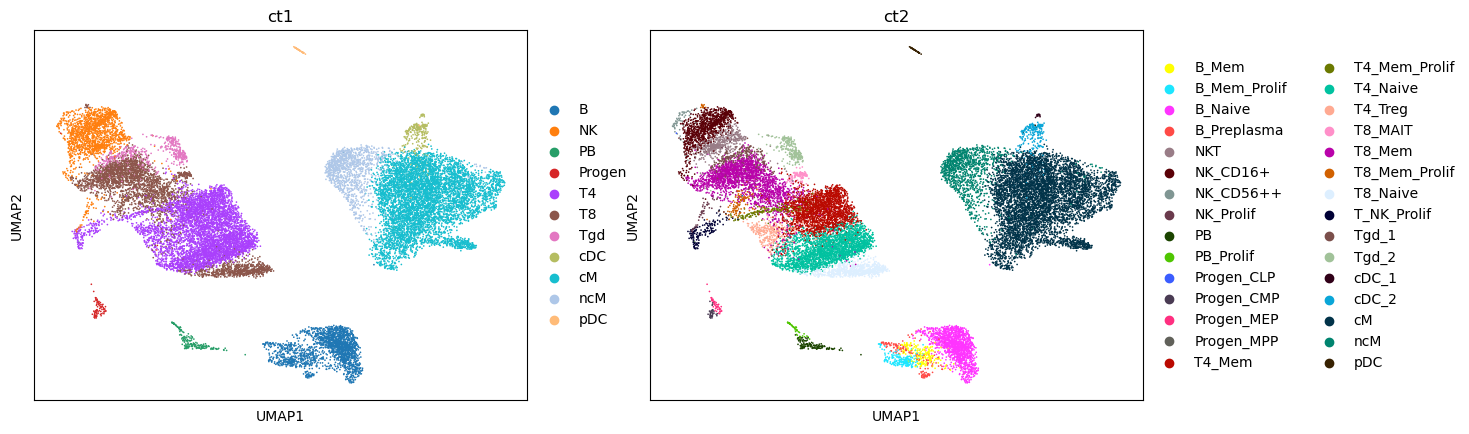

In [9]:
sc.pl.umap(adata_exp,
           color=['ct1','ct2']
          )

In [ ]:
ame="SJ.out.tab

### Load Splice Junction Matricies into scQuint

In [14]:
input_dir = "/nowakowskilab/data1/derek/data_scSLR/PBMC/STAR_outs/"

In [18]:
adatas_spl = {}
samples = ["sample_1", "sample_2"]
for sample in samples:
    print(sample)
    try:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/StarOut_merged/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    except:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/StarOut_merged/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    adatas_spl[sample] = adata_spl_sample

sample_1
Filtering out undefined strand.
sample_2
Filtering out undefined strand.


In [19]:
adata_spl = anndata.concat(adatas_spl, index_unique="-", merge="same")
adata_spl

AnnData object with n_obs × n_vars = 1474560 × 415831
    var: 'chromosome', 'start', 'end', 'strand', 'intron_motif'

In [26]:
##fix obs names
adata_spl.obs_names = adata_spl.obs_names.str.replace('-sample_1','-1-22').str.replace('-sample_2','-1-23')

In [27]:
adata_spl = adata_spl[adata_exp.obs.index.values]
adata_spl.obs = adata_exp.obs
adata_spl.obsm["X_umap"] = adata_exp.obsm["X_umap"]
adata_spl

AnnData object with n_obs × n_vars = 20673 × 415831
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal'
    var: 'chromosome', 'start', 'end', '

In [28]:
sc.pp.filter_genes(adata_spl, min_cells=100)
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
adata_spl = adata_spl[:, adata_spl.var.chromosome.isin(chromosomes)]

In [29]:
%%time
##add annotations

gtf_path = '/c4/home/derek/data1/HDD-2/derek/reference/human_hp3_reference/genes/genes.gtf'
filter_unique_gene=True
    
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    header=None,
    comment="#",
    names=[
        "chromosome",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

gtf = gtf[gtf.feature == "exon"]
gtf["gene_id"] = gtf.attribute.str.extract(r'gene_id "([^;]*)";')
gtf["gene_name"] = gtf.attribute.str.extract(r'gene_name "([^;]*)";')
#gtf.chromosome = "chr" + gtf.chromosome.astype(str)

gene_id_name = gtf[["gene_id", "gene_name"]].drop_duplicates()

exon_starts = (
    gtf[["chromosome", "start", "gene_id"]].copy().rename(columns={"start": "pos"})
)
exon_starts.pos -= 1
exon_ends = (
    gtf[["chromosome", "end", "gene_id"]].copy().rename(columns={"end": "pos"})
)
exon_ends.pos += 1
exon_boundaries = pd.concat(
    [exon_starts, exon_ends], ignore_index=True
).drop_duplicates()

genes_by_exon_boundary = exon_boundaries.groupby(
    ["chromosome", "pos"]
).gene_id.unique()

adata_spl.var = (
    adata_spl.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "start"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_start"})
    .set_index(adata_spl.var.index)
)
adata_spl.var = (
    adata_spl.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "end"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_end"})
    .set_index(adata_spl.var.index)
)

def fill_na_with_empty_array(val):
    return val if isinstance(val, np.ndarray) else np.array([])

adata_spl.var.gene_id_start = adata_spl.var.gene_id_start.apply(fill_na_with_empty_array)
adata_spl.var.gene_id_end = adata_spl.var.gene_id_end.apply(fill_na_with_empty_array)

adata_spl.var["gene_id_list"] = adata_spl.var.apply(
    lambda row: np.unique(np.concatenate([row.gene_id_start, row.gene_id_end])),
    axis=1,
)
adata_spl.var["n_genes"] = adata_spl.var.gene_id_list.apply(len)
adata_spl.var.gene_id_list = adata_spl.var.gene_id_list.apply(
    lambda x: ",".join(x.tolist())
)
adata_spl.var.gene_id_start = adata_spl.var.gene_id_start.apply(
    lambda x: ",".join(x.tolist())
)
adata_spl.var.gene_id_end = adata_spl.var.gene_id_end.apply(
    lambda x: ",".join(x.tolist())
)

if filter_unique_gene:
    print("Filtering to introns associated to 1 and only 1 gene.")
    adata_spl = adata_spl[:, adata_spl.var.n_genes == 1]
    adata_spl.var["gene_id"] = adata_spl.var.gene_id_list
    adata_spl.var.drop(columns=["gene_id_list",], inplace=True)
    adata_spl.var = adata_spl.var.merge(gene_id_name, how="left", on="gene_id").set_index(
        adata_spl.var.index
    )
    adata_spl.var.index = adata_spl.var.gene_name.astype(str) + "_" + adata_spl.var.index.astype(str)




Filtering to introns associated to 1 and only 1 gene.


<timed exec>:92: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


CPU times: user 3min 22s, sys: 24.1 s, total: 3min 46s
Wall time: 3min 34s


In [30]:
adata_spl = group_introns(adata_spl, by="three_prime")
adata_spl

Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/c4/home/derek/miniconda3/envs/scquint/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 20673 × 3282
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal'
    var: 'chromosome', 'start', 'end', 'st

In [40]:
adata_spl.write_h5ad(output_dir+'spl_3prime_splice_acceptor.h5ad')

In [35]:
!conda list

# packages in environment at /c4/home/derek/miniconda3/envs/scquint:
#
# Name                    Version                   Build  Channel
_ipython_minor_entry_point 8.7.0                hb6b4a82_0    conda-forge
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.8                h166bdaf_0    conda-forge
anndata                   0.8.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attr                      2.5.1                h166bdaf_1    conda-forge
attrs                     22.1.0             pyh71513ae_1    cond